In [2]:
import networkx as nx
import os
import sys
root = "/home/lisong/algorithms/graphtranssimulator"
#root = "C://Users//Administrator.DESKTOP-9T4A4SV//Dropbox//大湾区研究院工作文件夹//算法测试//graphtranssimulator"
#root = "/Users/MrBlackBean/Dropbox/lab_working_directory/algorithms/graphtranssimulator"
sys.path.append(root)
sys.path.append(os.path.join(root,"utils"))
sys.path.append(os.path.join(root,"src"))
sys.path.append(os.path.join(root,"algo"))
import zora
import pandas as pd
import heapq
from algo import *
import pickle

In [3]:
import json
import random
import csv
import copy
import logging
import numpy as np
from utils import *
from src import *
from collections import Counter, defaultdict
import matplotlib.pyplot as plt


In [4]:
def generate_sim_graph(conf, sim_name, resume_path=""):
    conf = os.path.join(root, conf)
    
    if resume_path != "":
        with open(resume_path,'rb') as f:
            T_Generator = pickle.load(f)
        return T_Generator
        
    # generate graph, no self-loops, allow multiedges
    G_generator = GraphGenerator(conf, sim_name, root)
    G_generator.set_num_accounts()
    graph = G_generator.generate_graph()
    
    # generate transaction information to graph
    T_generator = TransactionGenerator(G_generator)
    T_generator.assign_accounts_to_nodes()
    T_generator.generate_normal_transactions()
    T_generator.generate_alert_transactions()
    
    return T_generator

INFO:Generator:Exported 1446 accounts to /home/lisong/algorithms/graphtranssimulator/output/FirstTry/accounts.csv
INFO:Generator:Exported 10277 transactions to /home/lisong/algorithms/graphtranssimulator/output/FirstTry/transaction.csv
INFO:Generator:Output alert member list to: /home/lisong/algorithms/graphtranssimulator/output/FirstTry/alert_members.csv
INFO:Generator:Exported 589 members for 80 AML typologies to /home/lisong/algorithms/graphtranssimulator/output/FirstTry/alert_members.csv
INFO:Generator:Exported 18859 members for 9315 normal typologies to /home/lisong/algorithms/graphtranssimulator/output/FirstTry/normal_members.csv


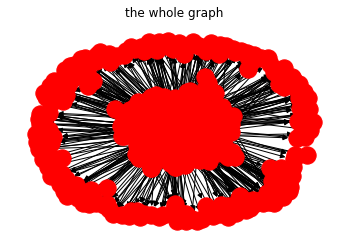

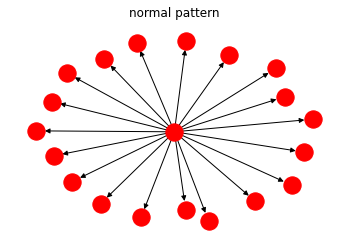

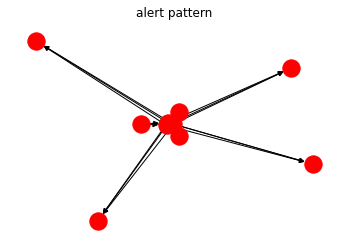

In [6]:
# generate graph
conf = "conf.json"
sim_name = "First_try"
resume_path="/home/lisong/algorithms/graphtranssimulator/pickle/FirstTry/graph.pickle"
#resume_path = ""
Generator = generate_sim_graph(conf,sim_name,resume_path)
#Generator = generate_sim_graph(conf, sim_name)

do_write = True
if do_write:
    write_to_csv(Generator)
    path = "/home/lisong/algorithms/graphtranssimulator/pickle/FirstTry/graph.pickle"
    write_to_pickle(Generator, path)

do_test = True
if run_test:
    normal_num = 1
    alert_num = 45
    run_test(Generator,normal_num,alert_num)
      

In [ ]:
# implement algorithms
algo = "EdMot"
vis = True

if algo == "zora_lcd":
    if not os.path.exists("/home/lisong/algorithms/graphtranssimulator/algo_output/zora/lcd_result.csv"):
        # run lcd algorithm
        lcd_result = run_model(Generator)
        print(lcd_result)
        lcd_result.to_csv("/home/lisong/algorithms/graphtranssimulator/algo_output/zora/lcd_result.csv",index=False)


    csv_file = "/home/lisong/algorithms/graphtranssimulator/algo_output/zora/lcd_result.csv"
    lcd_result = pd.read_csv(csv_file)
    
    if vis == True:
        group = 10
        g = Generator.g
        group_nodes = list(lcd_result[lcd_result["group"]==group]["cust_id"])
        print(group_nodes)
        sub_graph = nx.subgraph(g,group_nodes)
        plt.figure()
        plt.title("zora_lcd")
        nx.draw(sub_graph)

if algo == "EdMot":
    edge_path = "/home/lisong/algorithms/graphtranssimulator/output/FirstTry/transaction_noindex.csv"
    membership_path = "/home/lisong/algorithms/graphtranssimulator/algo_output/EdMot/membership.json"
    components = 10
    cutoff = 3
    graph = graph_reader(edge_path)
    model = EdMot(graph, components, cutoff)
    memberships = model.fit()
    membership_saver(membership_path, memberships)   
    print("number of groups is :", len(set([group for (node, group) in memberships.items()])))
    
    if vis == True:
        group_num = 0
        g = Generator.g
        group_nodes = [node for (node, group) in memberships.items() if group == group_num]
        print("number of nodes in group {} is {}".format(str(group_num),str(len(group_nodes))))
        sub_graph = nx.subgraph(g, group_nodes)
        plt.figure()
        plt.title("EdMot result")
        nx.draw(sub_graph)

if algo == "evolveGCN":
    EGCN_data_dir = "/home/lisong/algorithms/graphtranssimulator/algo_output/EvolveGCN"
    graph_path = "/home/lisong/algorithms/graphtranssimulator/pickle/FirstTry/graph.pickle"
    # generate
    generate_EGCN_data(graph_path)
    
        
# calculate the ratio of sar account
total = 0
is_sar = 0
for node in sub_graph.nodes():
    total += 1
    if "is_sar" in sub_graph.nodes[node] and sub_graph.nodes[node]["is_sar"]=="TRUE":
        is_sar += 1
print("{} of {} is fraud account, the acuracy is {}".format(is_sar, total, is_sar/total))

In [ ]:
# calculate metrics
from sklearn.metrics import precision_recall_fscore_support
g = Generator.g
real = []
pred = []
for n in g.nodes:
    if 'is_sar' in g.nodes[n] and g.nodes[n]["is_sar"]=="TRUE":
        real.append(1)
    else:
        real.append(0)
    if n in group_nodes:
        pred.append(1)
    else:
        pred.append(0)
print("The precision, recall and fscore are: ", precision_recall_fscore_support(sar, det, average='macro'))

In [19]:
g = Generator.g
dates = []
for e in g.edges:
    dates.append(g.edges[e]["date"])
print(max(dates),min(dates))

[{'amount': 133.8129498004655, 'date': 62, 'type': 'stack', 'edge_id': 9949, 'IS_SAR_KEY': 'TRUE', 'IS_ALERT_KEY': True}, {'edge_id': 60, 'amount': 100.0, 'date': 183, 'type': 'mutual', 'is_normal': True}, {'amount': 192.95311257590998, 'date': 173, 'type': 'cycle', 'edge_id': 9753, 'IS_SAR_KEY': 'TRUE', 'IS_ALERT_KEY': True}, {'edge_id': 245, 'amount': 120.0, 'date': 329, 'type': 'fan_in', 'is_normal': True}, {'amount': 126.43244971422482, 'date': 972, 'type': 'scatter_gather', 'edge_id': 10182, 'IS_SAR_KEY': 'TRUE', 'IS_ALERT_KEY': True}, {'edge_id': 354, 'amount': 120.0, 'date': 315, 'type': 'fan_in', 'is_normal': True}, {'edge_id': 360, 'amount': 150.0, 'date': 187, 'type': 'fan_in', 'is_normal': True}, {'edge_id': 374, 'amount': 110.0, 'date': 908, 'type': 'fan_in', 'is_normal': True}, {'amount': 157.62781848507169, 'date': 853, 'type': 'scatter_gather', 'edge_id': 10193, 'IS_SAR_KEY': 'TRUE', 'IS_ALERT_KEY': True}, {'amount': 166.46970246341215, 'date': 852, 'type': 'scatter_gath

TypeError: '>' not supported between instances of 'dict' and 'dict'